## Consider the College data from the ISLP package. Details about the data is described on page 65 of the ISLP textbook for this class (https://islp.readthedocs.io/en/latest/datasets/College.html). We would like to predict the number of applications received using the other variables. 80% of the data (randomly generated) will be treated as training data. The rest will be the test data.

In [86]:
%%capture
# importlib.util allows us to check whether a package is already installed
import importlib.util

# Check if the ISLP package is available in the current Jupyter kernel
if importlib.util.find_spec("ISLP") is None:
    # Install ISLP if it is not already installed
    !pip install ISLP

In [87]:
def setup_environment():
    global pd, np, sm, sns, load_data, MS, train_test_split, mean_squared_error, plot_tree 
    global DecisionTreeRegressor, plt, GridSearchCV, BaggingRegressor, RandomForestRegressor 
    global LinearDiscriminantAnalysis, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
    global QuadraticDiscriminantAnalysis, KNeighborsClassifier, StandardScaler

    import pandas as pd
    import numpy as np
    import seaborn as sns
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from ISLP import load_data
    from ISLP.models import ModelSpec as MS
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.tree import plot_tree
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import BaggingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.preprocessing import StandardScaler
    

    np.random.seed(42)

setup_environment()


### a) Fit a linear model using least squares and report the estimate of the test error.

In [88]:
# load college dataset
college = load_data("College")

# Split the data into 80% training and 20% test sets
train_df, test_df = train_test_split(college, test_size=0.2, random_state=42)

# Fit a linear model using least squares (OLS)
# Remove response from predictors
predictors = train_df.columns.drop("Apps")

design = MS(predictors)
design = design.fit(train_df)

# Create the design matrices for training and testing data
X_train = design.transform(train_df)
y_train = train_df["Apps"]
X_test = design.transform(test_df)
y_test = test_df["Apps"]

# Fit the OLS model using statsmodels
model = sm.OLS(y_train, X_train)
results = model.fit()

# Training error
train_predictions = results.predict(X_train)
train_error = mean_squared_error(y_train, train_predictions)

# Test error
test_predictions = results.predict(X_test)
test_error = mean_squared_error(y_test, test_predictions)

print(f"Training MSE: {train_error:.2f}")
print(f"Test MSE: {test_error:.2f}")

Training MSE: 990105.97
Test MSE: 1492443.38


### b) Fit a tree to the data. Summarize the results. Unless the number of terminal nodes is large, display the tree graphically. Report its MSE.

Training MSE: 2210346.70
Test MSE:     1868176.06


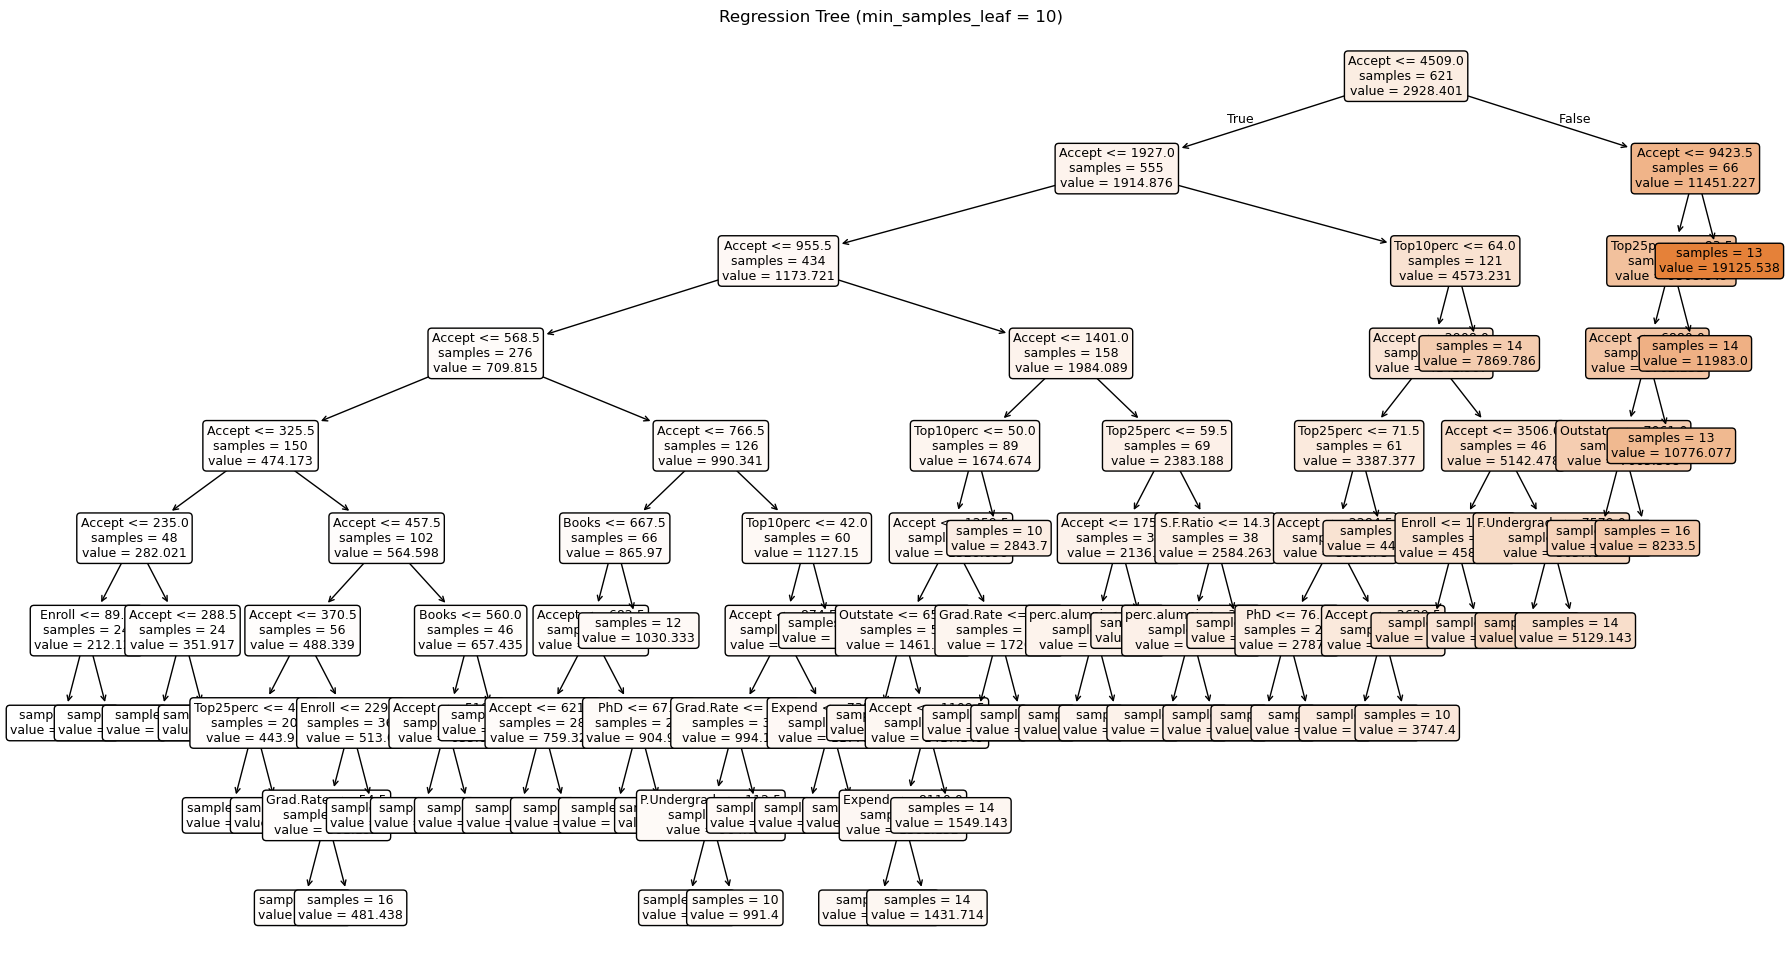

In [97]:
# Encode categorical variable (safe for re-runs)
if "Private" in college.columns:
    college = pd.get_dummies(college, columns=["Private"], drop_first=True)
    college["Private_Yes"] = college["Private_Yes"].astype(int)

# Predictors and response
X = college.drop("Apps", axis=1)
y = college["Apps"]

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit regression tree with mild regularization
tree_model = DecisionTreeRegressor(
    min_samples_leaf=10,   # prevents interpolation
    random_state=42
)
tree_model.fit(X_train, y_train)

# Training error
train_pred = tree_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)

# Test error
test_pred = tree_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)

print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE:     {test_mse:.2f}")

# ----------------------------
# Plot the tree
# ----------------------------
plt.figure(figsize=(22, 12))
plot_tree(
    tree_model,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    impurity=False,
    fontsize=9
)
plt.title("Regression Tree (min_samples_leaf = 10)")
# save
plt.savefig("Tree.jpg", dpi=300, bbox_inches="tight")
plt.show()



### c) Use Cross validation to determine whether pruning is helpful and determine the optimal size for the pruned tree. Compare the pruned and un-pruned trees. Report MSE for the pruned tree. Which predictors seem to be the most important?

Optimal ccp_alpha: 13432.314469168236
Pruned Tree Training MSE: 228,190.18
Pruned Tree Test MSE:     1,505,670.86


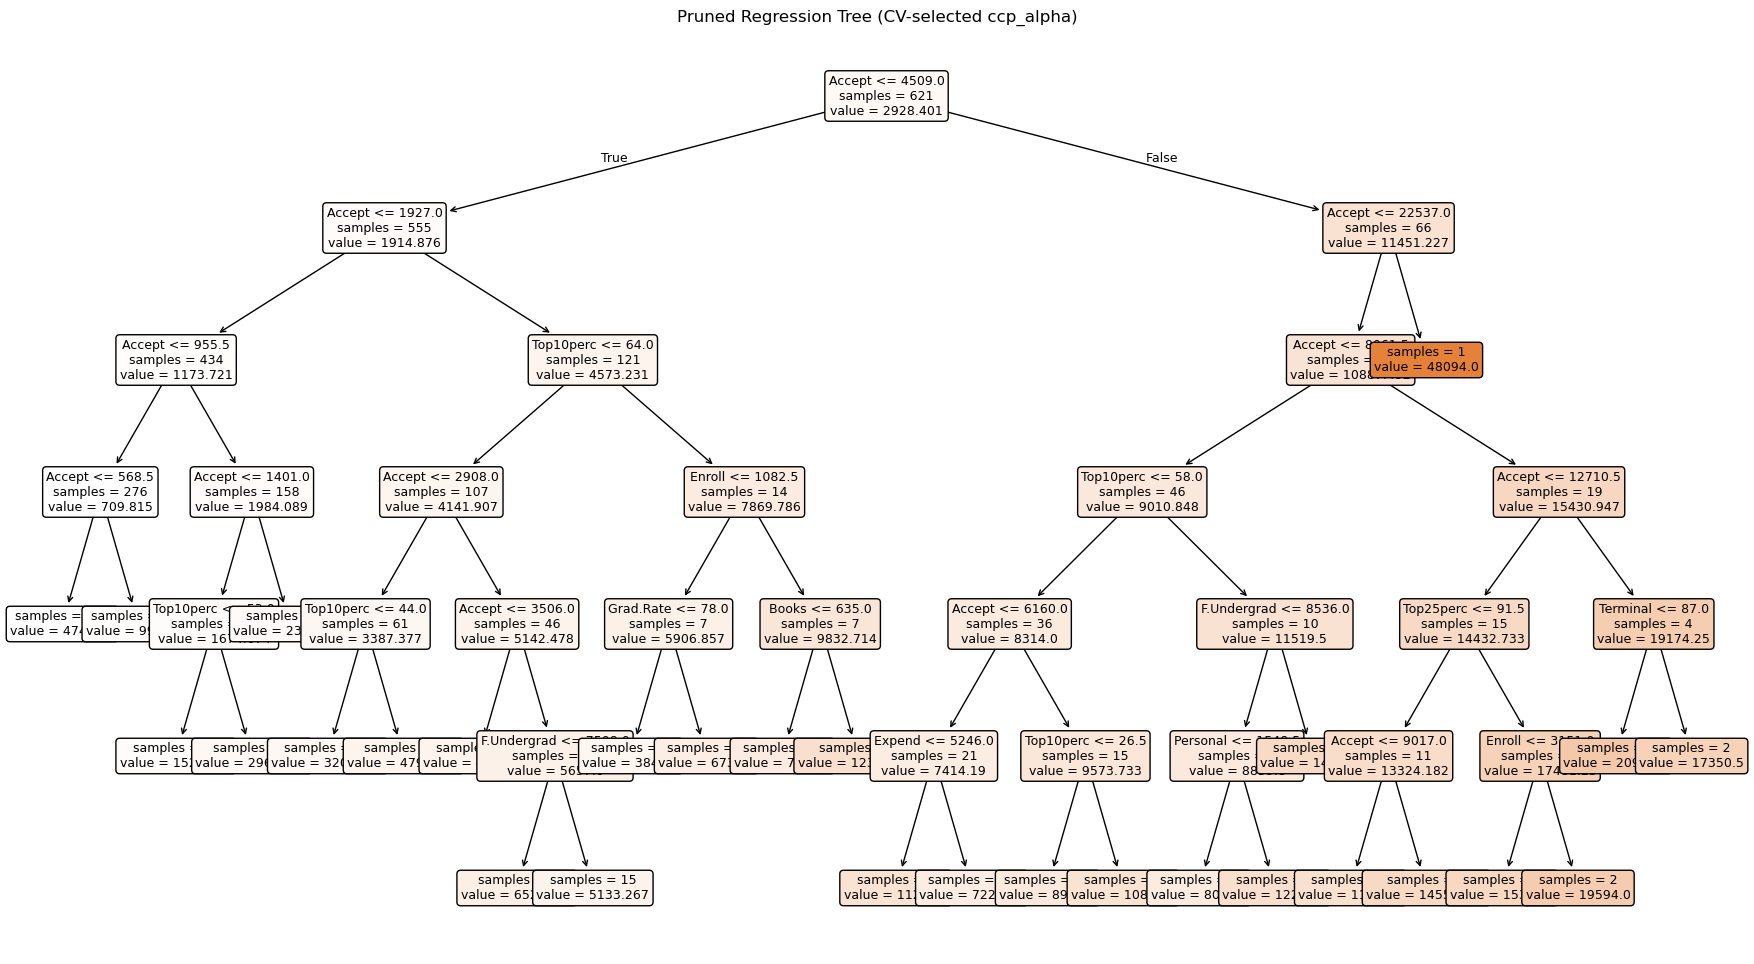


Most Important Predictors (Pruned Tree):
Accept         0.937313
Top10perc      0.031655
F.Undergrad    0.008701
Enroll         0.007646
Top25perc      0.005398
dtype: float64


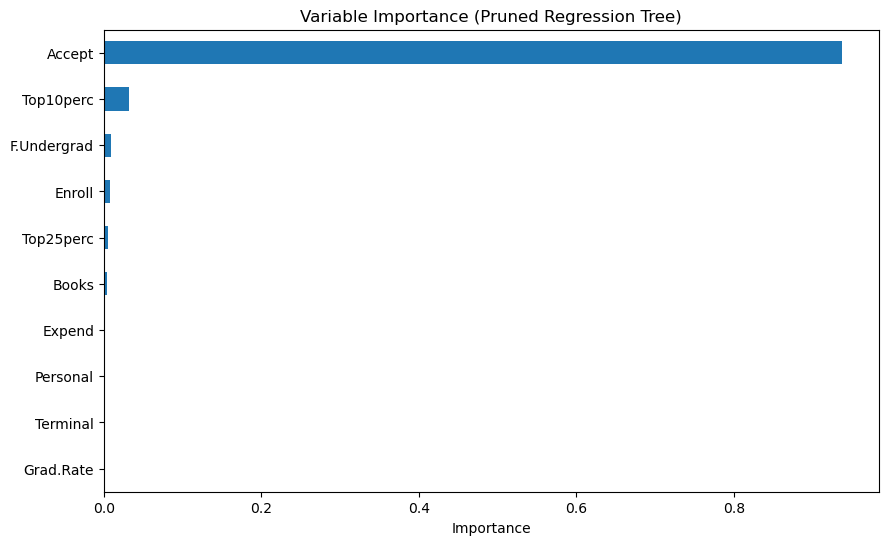

In [90]:
# cost–complexity pruning path using training data
base_tree = DecisionTreeRegressor(random_state=42)
path = base_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# cross-validation to select the optimal ccp_alpha
param_grid = {"ccp_alpha": ccp_alphas}
grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error"
)
grid.fit(X_train, y_train)

optimal_ccp_alpha = grid.best_params_["ccp_alpha"]
print(f"Optimal ccp_alpha: {optimal_ccp_alpha}")

# fit the pruned regression tree using the selected ccp_alpha
pruned_tree = DecisionTreeRegressor(
    ccp_alpha=optimal_ccp_alpha,
    random_state=42
)
pruned_tree.fit(X_train, y_train)

# compute training and test predictions
train_pred = pruned_tree.predict(X_train)
test_pred  = pruned_tree.predict(X_test)

# compute training and test mean squared error
train_mse = mean_squared_error(y_train, train_pred)
test_mse  = mean_squared_error(y_test, test_pred)

print(f"Pruned Tree Training MSE: {train_mse:,.2f}")
print(f"Pruned Tree Test MSE:     {test_mse:,.2f}")

# plot the pruned regression tree
plt.figure(figsize=(22, 12))
plot_tree(
    pruned_tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    impurity=False,
    fontsize=9
)
plt.title("Pruned Regression Tree (CV-selected ccp_alpha)")
plt.savefig("Pruned Regression Tree (CV-selected ccp_alpha).jpg", dpi=300, bbox_inches="tight")
plt.show()

# compute variable importance from the pruned tree
feature_importance = pd.Series(
    pruned_tree.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print("\nMost Important Predictors (Pruned Tree):")
print(feature_importance.head())

# plot variable importance for the top predictors
plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Variable Importance (Pruned Regression Tree)")
plt.savefig("Variable Importance (Pruned Regression Tree).jpg", dpi=300, bbox_inches="tight")
plt.show()


### d) Use a bagging approach to analyze the data with B = 500 and B = 1000. Compute the MSE. Which predictors seem to be the most important?

Bagging (B = 500) Training MSE: 324,906.52
Bagging (B = 500) Test MSE:     991,954.09

Bagging (B = 1000) Training MSE: 331,497.47
Bagging (B = 1000) Test MSE:     994,984.32

Random Forest (Bagging) Training MSE: 333,939.32
Random Forest (Bagging) Test MSE:     1,019,777.11

Most Important Predictors:
Accept         0.917885
Top10perc      0.019057
Top25perc      0.010853
Enroll         0.008846
F.Undergrad    0.005891
Outstate       0.005640
Expend         0.005354
Grad.Rate      0.005158
S.F.Ratio      0.003440
perc.alumni    0.003235
dtype: float64


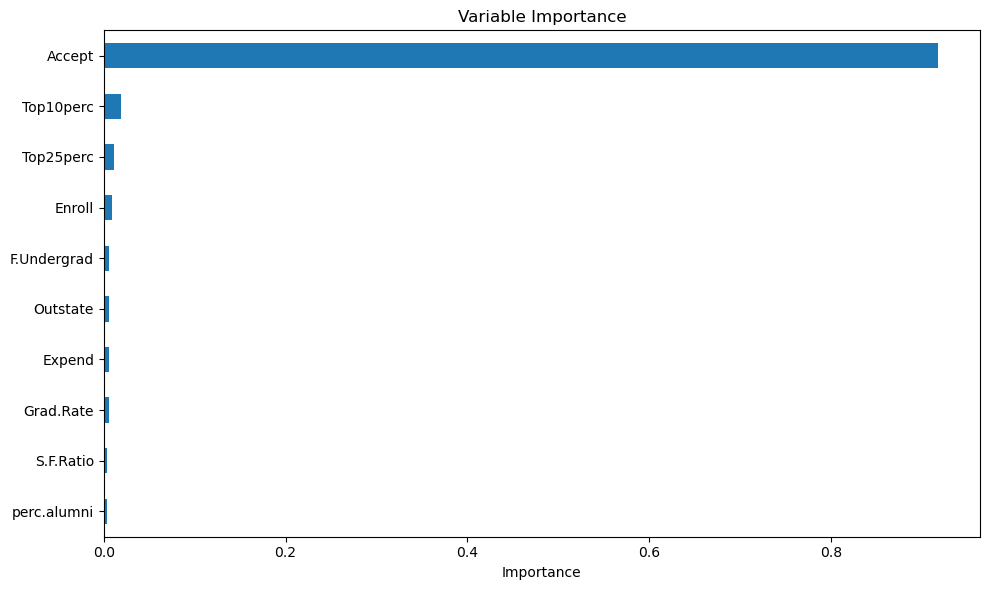

In [91]:
# predictors and response
X = college.drop("Apps", axis=1)
y = college["Apps"]
feature_names = X.columns

# train–test split (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------------------------------
# Bagging with regression trees
# --------------------------------------------------
def fit_bagging(n_estimators):

    model = BaggingRegressor(
        estimator=DecisionTreeRegressor(),
        n_estimators=n_estimators,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    # training error
    train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, train_pred)

    # test error
    test_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_pred)

    return train_mse, test_mse, model


# Bagging with B = 500
train_mse_500, test_mse_500, bag_500 = fit_bagging(500)
print(f"Bagging (B = 500) Training MSE: {train_mse_500:,.2f}")
print(f"Bagging (B = 500) Test MSE:     {test_mse_500:,.2f}")

# Bagging with B = 1000
train_mse_1000, test_mse_1000, bag_1000 = fit_bagging(1000)
print(f"\nBagging (B = 1000) Training MSE: {train_mse_1000:,.2f}")
print(f"Bagging (B = 1000) Test MSE:     {test_mse_1000:,.2f}")


# --------------------------------------------------
# Random Forest in bagging mode (m = p)
# --------------------------------------------------
rf_bagging = RandomForestRegressor(
    n_estimators=1000,
    max_features=len(feature_names),   # m = p → pure bagging
    random_state=42,
    n_jobs=-1
)

rf_bagging.fit(X_train, y_train)

# training error
rf_train_pred = rf_bagging.predict(X_train)
rf_train_mse = mean_squared_error(y_train, rf_train_pred)

# test error
rf_test_pred = rf_bagging.predict(X_test)
rf_test_mse = mean_squared_error(y_test, rf_test_pred)

print(f"\nRandom Forest (Bagging) Training MSE: {rf_train_mse:,.2f}")
print(f"Random Forest (Bagging) Test MSE:     {rf_test_mse:,.2f}")


# --------------------------------------------------
# Variable importance (Random Forest)
# --------------------------------------------------
feature_importance = pd.Series(
    rf_bagging.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print("\nMost Important Predictors:")
print(feature_importance.head(10))

# plot variable importance
plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Variable Importance")
plt.tight_layout()
plt.savefig("Variable Importance.jpg", dpi=300, bbox_inches="tight")
plt.show()


### e) Repeat (d) with a random forest approach with B = 500 and B = 1000, and m ≈ p = 3.

Random Forest (B=500, m≈p/3) Training MSE: 355,504.74
Random Forest (B=500, m≈p/3) Test MSE:     1,123,957.91

Random Forest (B=1000, m≈p/3) Training MSE: 359,051.81
Random Forest (B=1000, m≈p/3) Test MSE:     1,093,041.67

Most Important Predictors:
Accept         0.376426
Enroll         0.225318
F.Undergrad    0.144657
P.Undergrad    0.043980
Grad.Rate      0.025565
Top25perc      0.024516
Expend         0.021722
Top10perc      0.018287
PhD            0.018195
Private_Yes    0.018137
Outstate       0.017656
Room.Board     0.015750
S.F.Ratio      0.013631
Terminal       0.012255
Personal       0.010268
Books          0.007173
perc.alumni    0.006464
dtype: float64


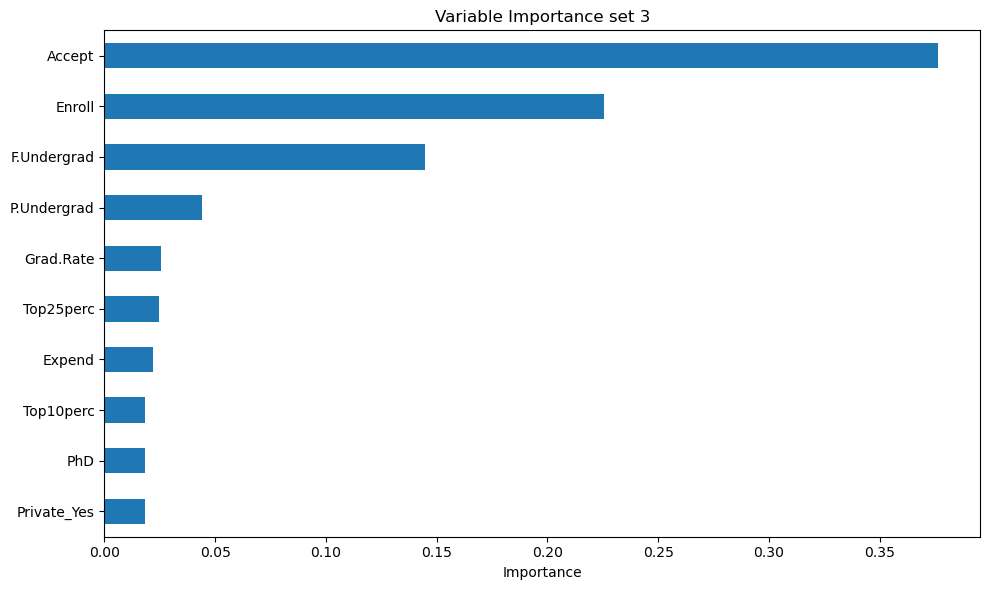

In [92]:
# number of predictors and m ≈ p/3
p = X.shape[1]
m_3 = max(1, p // 3)

# -----------------------------
# Random Forest: B = 500, m ≈ p/3
# -----------------------------
rf_500_3 = RandomForestRegressor(
    n_estimators=500,
    max_features=m_3,
    random_state=42,
    n_jobs=-1
)

rf_500_3.fit(X_train, y_train)

rf_500_3_train_pred = rf_500_3.predict(X_train)
rf_500_3_test_pred  = rf_500_3.predict(X_test)

rf_500_3_train_mse = mean_squared_error(y_train, rf_500_3_train_pred)
rf_500_3_test_mse  = mean_squared_error(y_test, rf_500_3_test_pred)

print(f"Random Forest (B=500, m≈p/3) Training MSE: {rf_500_3_train_mse:,.2f}")
print(f"Random Forest (B=500, m≈p/3) Test MSE:     {rf_500_3_test_mse:,.2f}")

# -----------------------------
# Random Forest: B = 1000, m ≈ p/3
# -----------------------------
rf_1000_3 = RandomForestRegressor(
    n_estimators=1000,
    max_features=m_3,
    random_state=42,
    n_jobs=-1
)

rf_1000_3.fit(X_train, y_train)

rf_1000_3_train_pred = rf_1000_3.predict(X_train)
rf_1000_3_test_pred  = rf_1000_3.predict(X_test)

rf_1000_3_train_mse = mean_squared_error(y_train, rf_1000_3_train_pred)
rf_1000_3_test_mse  = mean_squared_error(y_test, rf_1000_3_test_pred)

print(f"\nRandom Forest (B=1000, m≈p/3) Training MSE: {rf_1000_3_train_mse:,.2f}")
print(f"Random Forest (B=1000, m≈p/3) Test MSE:     {rf_1000_3_test_mse:,.2f}")

# -----------------------------
# Feature importance (use B = 1000, m ≈ p/3)
# -----------------------------
feature_importance_1000_3 = pd.Series(
    rf_1000_3.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print("\nMost Important Predictors:")
print(feature_importance_1000_3)

# plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_1000_3.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Variable Importance set 3")
plt.tight_layout()
plt.savefig("Variable Importance set 3.jpg", dpi=300, bbox_inches="tight")
plt.show()


## 2. Consider the business school admission data available in the admission.csv. The admission officer of a business school has used an “index” of undergraduate grade point average (GPA,𝑋1) and graduate management aptitude test (GMAT,𝑋2) scores to help decide which applicants should be admitted to the school’s graduate programs. This index is used to categorize each applicant into one of three groups – admit (group 1), do not admit (group 2), and borderline (group 3). We will take the last four observations in each category as test data and the remaining observations as training data.

### a) Perform an exploratory analysis of the training data by examining appropriate plots and comment on how helpful these predictors may be in predicting response.

Training data shape: (73, 4)
Test data shape: (12, 4)

Summary statistics (training data):
        GPA                                                         GMAT  \
      count      mean       std   min     25%    50%     75%   max count   
Group                                                                      
1      27.0  3.383333  0.194501  2.96  3.2700  3.390  3.4900  3.78  27.0   
2      24.0  2.437083  0.145766  2.13  2.3575  2.435  2.5425  2.68  24.0   
3      22.0  2.994545  0.184900  2.73  2.8675  3.005  3.1100  3.50  22.0   

                                                                   
             mean        std    min     25%    50%     75%    max  
Group                                                              
1      563.148148  68.151248  431.0  525.00  563.0  600.50  693.0  
2      451.083333  61.670172  321.0  410.25  452.0  504.25  542.0  
3      445.727273  50.582494  313.0  419.00  445.0  481.50  546.0  


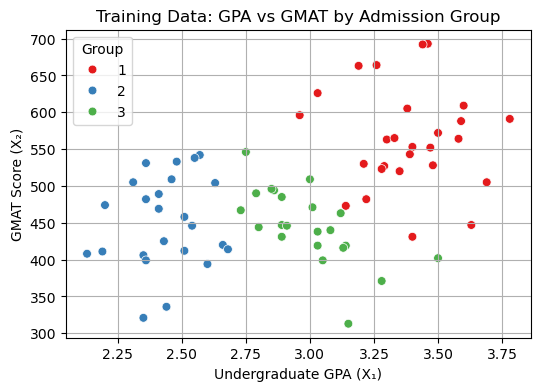

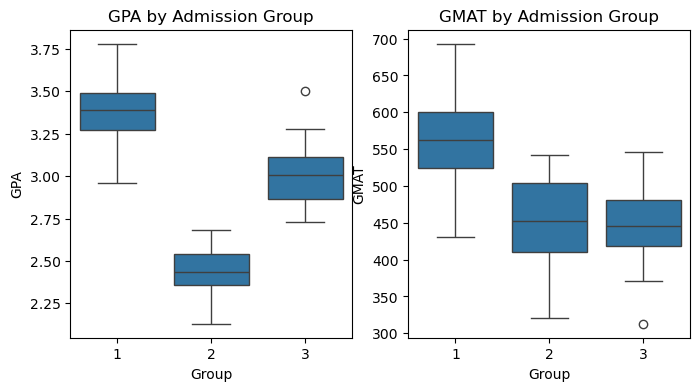

In [93]:
# Load the dataset
admission = pd.read_csv("admission.csv")

# Split into training and test data
# last 4 observations in each group are test data

train_parts = []
test_parts = []

for _, group_df in admission.groupby("Group"):
    train_parts.append(group_df.iloc[:-4])
    test_parts.append(group_df.iloc[-4:])

train_df = pd.concat(train_parts).reset_index(drop=True)
test_df = pd.concat(test_parts).reset_index(drop=True)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Summary statistics (training data only)
print("\nSummary statistics (training data):")
print(train_df.groupby("Group")[["GPA", "GMAT"]].describe())

# Scatter plot: GPA vs GMAT
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=train_df,
    x="GPA",
    y="GMAT",
    hue="Group",
    palette="Set1",
    s=40
)
plt.title("Training Data: GPA vs GMAT by Admission Group")
plt.xlabel("Undergraduate GPA (X₁)")
plt.ylabel("GMAT Score (X₂)")
plt.grid(True)
# save
plt.savefig("scatter_gpa_gmat.jpg", dpi=300, bbox_inches="tight")
plt.show()

# Boxplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(data=train_df, x="Group", y="GPA", ax=axes[0])
axes[0].set_title("GPA by Admission Group")

sns.boxplot(data=train_df, x="Group", y="GMAT", ax=axes[1])
axes[1].set_title("GMAT by Admission Group")
# save
plt.savefig("boxplots_gpa_gmat.jpg", dpi=300, bbox_inches="tight")
plt.show()


### b) Perform an LDA using the training data. Superimpose the decision boundary on an appropriate display of the data. Does the decision boundary seem sensible? In addition, compute the confusion matrix and overall misclassification rate based on both training and test data. What do you observe?


Estimated Test Error Rate: 0.250
Confusion Matrix (Training Data):
    1   2   3
1  25   0   2
2   0  24   0
3   1   0  21

Confusion Matrix (Test Data):
   1  2  3
1  3  0  1
2  0  2  2
3  0  0  4

Sensitivity and Specificity by Class:
   Sensitivity (Train)  Specificity (Train)  Sensitivity (Test)  \
1             0.925926             0.978261                0.75   
2             1.000000             1.000000                0.50   
3             0.954545             0.960784                1.00   

   Specificity (Test)  
1               1.000  
2               1.000  
3               0.625  

Macro-Averaged Metrics (Test Data):
Sensitivity: 0.750
Specificity: 0.875

Training AUC (OvR, macro): 0.997


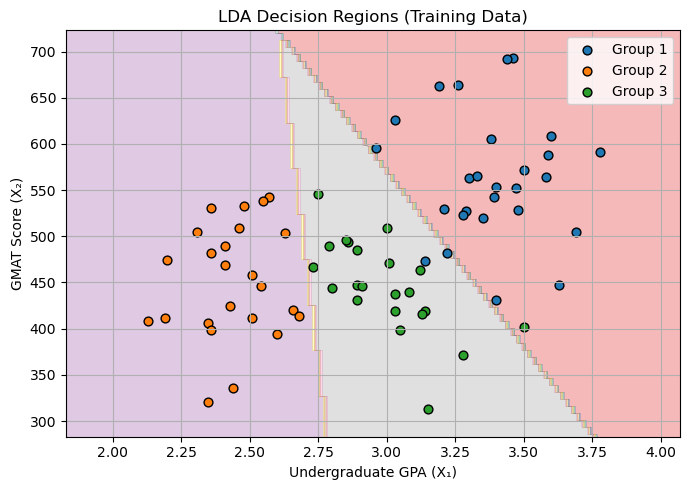

In [94]:
# predictors and response
X_train = train_df[["GPA", "GMAT"]]
y_train = train_df["Group"]

X_test = test_df[["GPA", "GMAT"]]
y_test = test_df["Group"]

# fit LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# predictions
y_train_pred = lda.predict(X_train)
y_test_pred  = lda.predict(X_test)

# estimated test error rate
test_error_rate = 1 - accuracy_score(y_test, y_test_pred)
print(f"\nEstimated Test Error Rate: {test_error_rate:.3f}")

# confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test, y_test_pred)

classes = lda.classes_

print("Confusion Matrix (Training Data):")
print(pd.DataFrame(cm_train, index=classes, columns=classes))

print("\nConfusion Matrix (Test Data):")
print(pd.DataFrame(cm_test, index=classes, columns=classes))

# sensitivity and specificity (one-vs-rest)
def sensitivity_specificity(cm, classes):
    sens = {}
    spec = {}
    total = cm.sum()

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FN + FP)

        sens[cls] = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        spec[cls] = TN / (TN + FP) if (TN + FP) > 0 else np.nan

    return sens, spec

# training metrics
sens_train, spec_train = sensitivity_specificity(cm_train, classes)

# test metrics
sens_test, spec_test = sensitivity_specificity(cm_test, classes)

metrics_df = pd.DataFrame({
    "Sensitivity (Train)": sens_train,
    "Specificity (Train)": spec_train,
    "Sensitivity (Test)": sens_test,
    "Specificity (Test)": spec_test
})

print("\nSensitivity and Specificity by Class:")
print(metrics_df)

print("\nMacro-Averaged Metrics (Test Data):")
print(f"Sensitivity: {np.nanmean(list(sens_test.values())):.3f}")
print(f"Specificity: {np.nanmean(list(spec_test.values())):.3f}")

# training AUC (multiclass, OvR, macro)
y_train_prob = lda.predict_proba(X_train)

auc_train = roc_auc_score(
    y_train,
    y_train_prob,
    multi_class="ovr",
    average="macro"
)

print(f"\nTraining AUC (OvR, macro): {auc_train:.3f}")

# LDA decision region plot (training data)
def plot_lda_decision_regions(X, y, model, title, filename):
    h = 0.02

    x_min, x_max = X["GPA"].min() - 0.3, X["GPA"].max() + 0.3
    y_min, y_max = X["GMAT"].min() - 30, X["GMAT"].max() + 30

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    grid = pd.DataFrame(
        np.c_[xx.ravel(), yy.ravel()],
        columns=["GPA", "GMAT"]
    )

    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)

    for cls in np.unique(y):
        plt.scatter(
            X.loc[y == cls, "GPA"],
            X.loc[y == cls, "GMAT"],
            label=f"Group {cls}",
            edgecolors="k",
            s=40
        )

    plt.xlabel("Undergraduate GPA (X₁)")
    plt.ylabel("GMAT Score (X₂)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

plot_lda_decision_regions(
    X_train,
    y_train,
    lda,
    title="LDA Decision Regions (Training Data)",
    filename="LDA_Decision_Regions.jpg"
)


### c) Repeat (b) using QDA.


Estimated Test Error Rate (QDA): 0.167
Confusion Matrix (Training Data):
    1   2   3
1  26   0   1
2   0  24   0
3   1   0  21

Confusion Matrix (Test Data):
   1  2  3
1  4  0  0
2  0  2  2
3  0  0  4

Sensitivity and Specificity by Class:
   Sensitivity (Train)  Specificity (Train)  Sensitivity (Test)  \
1             0.962963             0.978261                 1.0   
2             1.000000             1.000000                 0.5   
3             0.954545             0.980392                 1.0   

   Specificity (Test)  
1                1.00  
2                1.00  
3                0.75  

Macro-Averaged Metrics (Test Data):
Sensitivity: 0.833
Specificity: 0.917

Training AUC (OvR, macro): 0.999


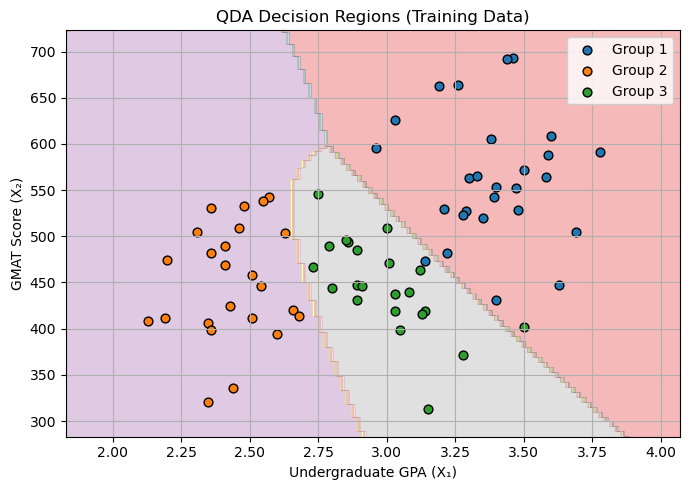

In [95]:
# predictors and response
X_train = train_df[["GPA", "GMAT"]]
y_train = train_df["Group"]

X_test = test_df[["GPA", "GMAT"]]
y_test = test_df["Group"]

# fit QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# predictions
y_train_pred = qda.predict(X_train)
y_test_pred  = qda.predict(X_test)

# estimated test error rate
test_error_rate = 1 - accuracy_score(y_test, y_test_pred)
print(f"\nEstimated Test Error Rate (QDA): {test_error_rate:.3f}")

#  confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test, y_test_pred)

classes = qda.classes_

print("Confusion Matrix (Training Data):")
print(pd.DataFrame(cm_train, index=classes, columns=classes))

print("\nConfusion Matrix (Test Data):")
print(pd.DataFrame(cm_test, index=classes, columns=classes))

# sensitivity and specificity (one-vs-rest)
def sensitivity_specificity(cm, classes):
    sens = {}
    spec = {}
    total = cm.sum()

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FN + FP)

        sens[cls] = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        spec[cls] = TN / (TN + FP) if (TN + FP) > 0 else np.nan

    return sens, spec

# training metrics
sens_train, spec_train = sensitivity_specificity(cm_train, classes)

# test metrics
sens_test, spec_test = sensitivity_specificity(cm_test, classes)

metrics_df = pd.DataFrame({
    "Sensitivity (Train)": sens_train,
    "Specificity (Train)": spec_train,
    "Sensitivity (Test)": sens_test,
    "Specificity (Test)": spec_test
})

print("\nSensitivity and Specificity by Class:")
print(metrics_df)

print("\nMacro-Averaged Metrics (Test Data):")
print(f"Sensitivity: {np.nanmean(list(sens_test.values())):.3f}")
print(f"Specificity: {np.nanmean(list(spec_test.values())):.3f}")

# training AUC (multiclass, OvR, macro)
y_train_prob = qda.predict_proba(X_train)

auc_train = roc_auc_score(
    y_train,
    y_train_prob,
    multi_class="ovr",
    average="macro"
)

print(f"\nTraining AUC (OvR, macro): {auc_train:.3f}")

# QDA decision region plot (training data)
def plot_qda_decision_regions(X, y, model, title, filename):
    h = 0.02

    x_min, x_max = X["GPA"].min() - 0.3, X["GPA"].max() + 0.3
    y_min, y_max = X["GMAT"].min() - 30, X["GMAT"].max() + 30

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    grid = pd.DataFrame(
        np.c_[xx.ravel(), yy.ravel()],
        columns=["GPA", "GMAT"]
    )

    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)

    for cls in np.unique(y):
        plt.scatter(
            X.loc[y == cls, "GPA"],
            X.loc[y == cls, "GMAT"],
            label=f"Group {cls}",
            edgecolors="k",
            s=40
        )

    plt.xlabel("Undergraduate GPA (X₁)")
    plt.ylabel("GMAT Score (X₂)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# plot QDA decision regions
plot_qda_decision_regions(
    X_train,
    y_train,
    qda,
    title="QDA Decision Regions (Training Data)",
    filename="QDA_Decision_Regions.jpg"
)


### d) Fit a KNN with K chosen optimally using test error rate. Report error rate, sensitivity, specificity, and AUC for the optimal KNN based on the training data. Also, report its estimated test error rate.

Training Error Rate: 0.0411
Sensitivity (macro-average): 0.9545
Specificity (macro-average): 0.9787
AUC (training, OvR): 0.9986
Estimated Test Error Rate: 0.0833
AUC (test, OvR): 0.9375


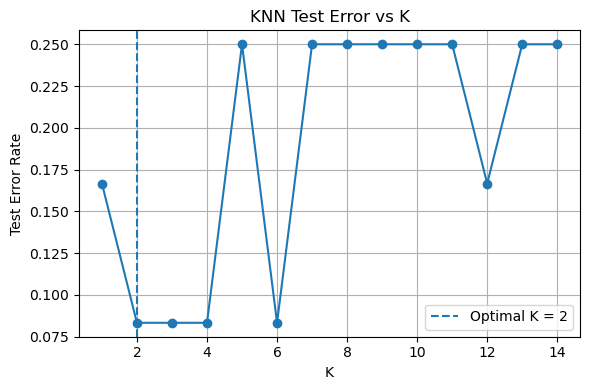

In [96]:
# --------------------------------------------------
# TRAINING DATA performance (continuation)
# --------------------------------------------------
y_train_pred = knn_opt.predict(X_train_scaled)
y_train_probs = knn_opt.predict_proba(X_train_scaled)

train_error = 1 - accuracy_score(y_train, y_train_pred)

cm_train = confusion_matrix(y_train, y_train_pred)

# sensitivity (recall) per class
sensitivity = np.diag(cm_train) / cm_train.sum(axis=1)

# specificity per class
specificity = []
for i in range(cm_train.shape[0]):
    tn = cm_train.sum() - (cm_train[i, :].sum() + cm_train[:, i].sum() - cm_train[i, i])
    fp = cm_train[:, i].sum() - cm_train[i, i]
    specificity.append(tn / (tn + fp))

sensitivity_macro = np.mean(sensitivity)
specificity_macro = np.mean(specificity)

auc_train = roc_auc_score(y_train, y_train_probs, multi_class="ovr", average="macro")

print(f"Training Error Rate: {train_error:.4f}")
print(f"Sensitivity (macro-average): {sensitivity_macro:.4f}")
print(f"Specificity (macro-average): {specificity_macro:.4f}")
print(f"AUC (training, OvR): {auc_train:.4f}")

# --------------------------------------------------
# TEST DATA performance (continuation)
# --------------------------------------------------
y_test_pred = knn_opt.predict(X_test_scaled)
y_test_probs = knn_opt.predict_proba(X_test_scaled)

test_error = 1 - accuracy_score(y_test, y_test_pred)

auc_test = roc_auc_score(y_test, y_test_probs, multi_class="ovr", average="macro")

print(f"Estimated Test Error Rate: {test_error:.4f}")
print(f"AUC (test, OvR): {auc_test:.4f}")

# plot test error vs K 
plt.figure(figsize=(6, 4))
plt.plot(k_range, test_errors, marker="o")
plt.axvline(optimal_k, linestyle="--", label=f"Optimal K = {optimal_k}")
plt.xlabel("K")
plt.ylabel("Test Error Rate")
plt.title("KNN Test Error vs K")
plt.legend()
plt.grid(True)
plt.tight_layout()
# save figure
plt.savefig("knn_test_error_vs_k.png", dpi=300, bbox_inches="tight")
plt.show()
